**Executed:** Mon Mar 27 11:45:14 2017

**Duration:** 75 seconds.

# Analysis of 5 smFRET samples

Burst statistics.

## Load FRETBursts software

In [1]:
from fretbursts import *
sns = init_notebook()

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.


--------------------------------------------------------------
 You are running FRETBursts (version 0.5.9).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [2]:
import os
import pandas as pd
from IPython.display import display

In [3]:
import lmfit
print('lmfit version:', lmfit.__version__)

lmfit version: 0.9.5


In [4]:
figure_size = (5, 4)
default_figure = lambda: plt.subplots(figsize=figure_size)
save_figures = True

def savefig(filename, **kwargs):
    if not save_figures:
        return
    import os
    dir_ = 'figures/'
    kwargs_ = dict(dpi=300, bbox_inches='tight')
                   #frameon=True, facecolor='white', transparent=False)
    kwargs_.update(kwargs)
    plt.savefig(dir_ + filename, **kwargs_)

## 8-spot paper plot style

In [5]:
PLOT_DIR = './figure/'

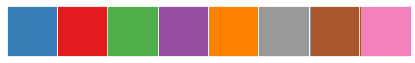

In [6]:
import matplotlib as mpl
from cycler import cycler

bmap = sns.color_palette("Set1", 9)
colors = np.array(bmap)[(1,0,2,3,4,8,6,7), :]
mpl.rcParams['axes.prop_cycle'] = cycler('color', colors)
colors_labels = ['blue', 'red', 'green', 'violet', 'orange', 'gray', 'brown', 'pink', ]
for c, cl in zip(colors, colors_labels):
    locals()[cl] = tuple(c) # assign variables with color names
sns.palplot(colors)

## Data files

Data folder:

In [7]:
data_dir = './data/multispot/'

Check that the folder exists:

In [8]:
data_dir = os.path.abspath(data_dir) + '/'
assert os.path.exists(data_dir), "Path '%s' does not exist." % data_dir

List of data files in `data_dir`:

In [9]:
from glob import glob
file_list = sorted(glob(data_dir + '*.hdf5'))

In [10]:
labels = ['7d', '12d', '17d', '22d', '27d', 'DO']
files_dict = {lab: fname for lab, fname in zip(sorted(labels), file_list)}
files_dict

{'12d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/12d_New_30p_320mW_steer_3.hdf5',
 '17d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/17d_100p_320mW_steer_1.hdf5',
 '22d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/22d_30p_320mW_steer_1.hdf5',
 '27d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/27d_50p_320mW_steer_1.hdf5',
 '7d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/7d_New_150p_320mW_steer_3.hdf5',
 'DO': '/Users/anto/Google Drive/notebooks/multispot_paper/data/multispot/DO12_No2_50p_320mW_steer_1.hdf5'}

## Parameters from file

Load the **leakage coefficient** from disk (computed in [Multi-spot 5-Samples analysis - Leakage coefficient - Summary](Multi-spot 5-Samples analysis - Leakage coefficient - Summary.ipynb)):

In [11]:
leakage_coeff_fname = 'results/Multi-spot - leakage coefficient KDE wmean DexDem.csv'
leakage = np.loadtxt(leakage_coeff_fname, ndmin=1)

print('Leakage coefficient:', leakage)

Leakage coefficient: [ 0.0334]


Load the **direct excitation coefficient** ($d_{dirT}$) from disk (computed in [usALEX - Corrections - Direct excitation physical parameter](usALEX - Corrections - Direct excitation physical parameter.ipynb)):

In [12]:
dir_ex_coeff_fname = 'results/usALEX - direct excitation coefficient dir_ex_t beta.csv'
dir_ex_t = np.loadtxt(dir_ex_coeff_fname, ndmin=1)

print('Direct excitation coefficient (dir_ex_t):', dir_ex_t)

Direct excitation coefficient (dir_ex_t): [ 0.04932]


In [13]:
gamma_fname = 'results/Multi-spot - gamma factor.csv'
gamma = np.loadtxt(gamma_fname, ndmin=1)

print('Multispot Gamma Factor (gamma):', gamma)

Multispot Gamma Factor (gamma): [ 0.45525]


# dsDNA Samples Processing

In [14]:
m = 10
F = 6
#leakage = leakage
rate_th = 25e3
ph_sel = Ph_sel(Dex='Dem')
nt_th1 = 50
bw_th1 = 1
pr_th1 = 310
E2 = 0.5 # threshold for selecting D-only population
Th_nt = np.arange(25, 100)
Th_bw = np.round(np.arange(0.5, 2, 0.1), 1)
Th_pr = np.arange(150, 600, 10)
bg_kwargs_auto = dict(fun=bg.exp_fit,
                 time_s = 30,
                 tail_min_us = 'auto',
                 F_bg=1.7,)
sel_do = 'unset'

In [15]:
cols = np.arange(1, 9)
s_th_ = pd.DataFrame(index=pd.Index(Th_nt, name='Size Threshold'), columns=cols)
s_th_.columns.name = 'Spot'
w_th_ = pd.DataFrame(index=pd.Index(Th_bw, name='Duration Threshold (ms)'), columns=cols)
w_th_.columns.name = 'Spot'
p_th_ = pd.DataFrame(index=pd.Index(Th_pr, name='Peak-Rate Threshold (kcps)'), columns=cols)
p_th_.columns.name = 'Spot'

In [16]:
s_F = {}
s_R = {}
w_F = {}
w_R = {}
p_F = {}
p_R = {}
bg1 = {}

In [17]:
def burst_mean_vs_th(dx):
    # globals: Th_nt, s_th_, Th_bw, w_th_, Th_pr, p_th_, m, ph_sel
    nt_th, nt_th_n = s_th_.copy(), s_th_.copy()
    for i, th in enumerate(Th_nt):
        dx_th = dx.select_bursts(select_bursts.size, th1=th)
        nt_th.iloc[i] = [(nd + na).mean() - th 
                         for nd, na in zip(dx_th.nd, dx_th.na)]
        nt_th_n.iloc[i] = dx_th.num_bursts
        
    bw_th, bw_th_n = w_th_.copy(), w_th_.copy()
    for i, th in enumerate(Th_bw):
        dx_th = dx.select_bursts(select_bursts.width, th1=th)
        bw_th.iloc[i] = [w.mean()*1e3 - th for w in dx_th.burst_widths]
        bw_th_n.iloc[i] = dx_th.num_bursts
    
    dx.calc_max_rate(m=m, ph_sel=ph_sel)
    pr_th, pr_th_n = p_th_.copy(), p_th_.copy()
    for i, th in enumerate(Th_pr):
        dx_th = dx.select_bursts(select_bursts.peak_phrate, th1=th*1e3)
        pr_th.iloc[i] = [r.mean()*1e-3 - th for r in dx_th.max_rate]
        pr_th_n.iloc[i] = dx_th.num_bursts

    return nt_th, bw_th, pr_th, nt_th_n, bw_th_n, pr_th_n

def _plot_mean_data_th(data, ndata):
    fig, ax = plt.subplots()
    legend_xpos = 1.05
    if ndata is not None:
        ax2 = ax.twinx()
        ndata.plot(ax=ax2, ls='--', legend=False, grid=False)
        legend_xpos = 1.10
    data.plot(lw=3, ax=ax)
    ax.set_ylim(0)  
    ax.legend(bbox_to_anchor=(legend_xpos, 1), loc=2, borderaxespad=0.);
    plt.sca(ax)
def plot_mean_size_th(data, ndata, title):
    _plot_mean_data_th(data, ndata)
    plt.ylabel('Burst Size (# Counts)')  
    plt.title('Mean Burst Size, ' + title)
def plot_mean_width_th(data, ndata, title):    
    _plot_mean_data_th(data, ndata)
    plt.ylabel('Burst Duration (ms)')
    plt.title('Mean Burst Duration, ' + title)
def plot_mean_phrate_th(data, ndata, title):    
    _plot_mean_data_th(data, ndata)
    plt.ylabel('Peak Photon Rate (kcps)')
    plt.title('Mean Peak Rate in Bursts, ' + title)
    
def select_do(dx):
    global sel_do
    sel_do = 'na=[-12,12]' 
    return dx.select_bursts(select_bursts.na, th1=-12, th2=12)

In [18]:
# ax = dplot(dxdo, hist_size);
# for a in ax.ravel():
#     a.axvline(nt_th1)

In [19]:
#ax = dplot(dxdo, hist_width);
#for a in ax.ravel():
#    a.axvline(nt_th1)

In [20]:
# dxdo.calc_max_rate(m=m)

# ax = dplot(dxdo, hist_burst_phrate);

# 7d sample

In [21]:
data_id = '7d'

In [22]:
dx = loader.photon_hdf5(files_dict[data_id])
dx.calc_bg(**bg_kwargs_auto)
bg1[data_id] = pd.Series([bd.mean() + ba.mean() for bd, ba in zip(dx.bg_dd, dx.bg_ad)], 
                         index=pd.Index(range(8), name='Ch'))
dx.leakage = leakage

 - Calculating BG rates ... 

[DONE]


**SBR Burst Search**

In [23]:
dx.burst_search(m=m, F=F, ph_sel=ph_sel)
dxdo = select_do(dx)

 - Performing burst search (verbose=False) ...

 - Recomputing background limits for DexDem ... 

[DONE]


 - Recomputing background limits for all ... 

[DONE]


 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [24]:
dx.rate_th

[10325.419116504232,
 11664.127589095389,
 31270.252580594093,
 16864.840388732937,
 13360.430149064472,
 14850.14075722909,
 11812.76052764648,
 10595.200224908369]

(-10, 50)

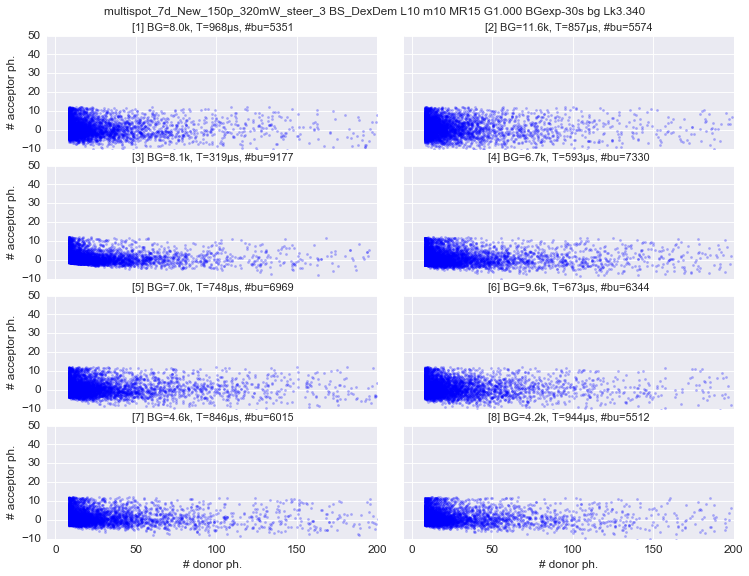

In [25]:
dplot(dxdo, scatter_da);
plt.ylim(-10, 50)

In [26]:
(nt_th_F, bw_th_F, pr_th_F,
 nt_th_F_n, bw_th_F_n, pr_th_F_n) = burst_mean_vs_th(dxdo)

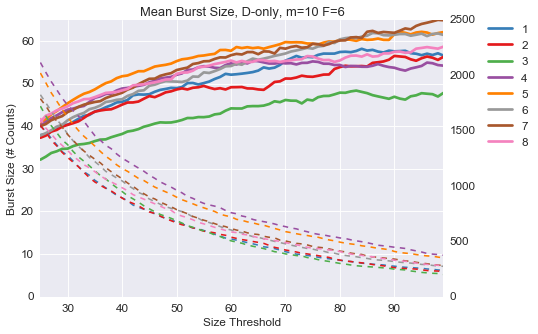

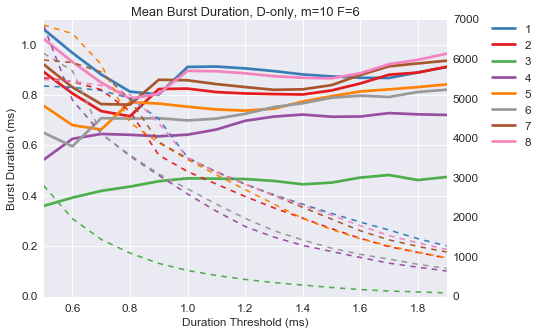

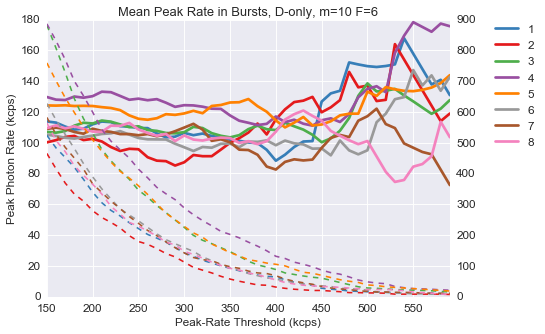

In [27]:
title = 'D-only, m=%d F=%d' % (m, F)
plot_mean_size_th(nt_th_F, nt_th_F_n, title=title)
plot_mean_width_th(bw_th_F, bw_th_F_n, title=title)
plot_mean_phrate_th(pr_th_F, pr_th_F_n, title=title)

**Fixed-rate Burst Search**

In [28]:
dx.burst_search(m=m, min_rate_cps=rate_th, ph_sel=ph_sel)
dxdo = select_do(dx)

 - Performing burst search (verbose=False) ...

 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [29]:
dx.rate_th

array([ 25000.,  25000.,  25000.,  25000.,  25000.,  25000.,  25000.,
        25000.])

(-10, 50)

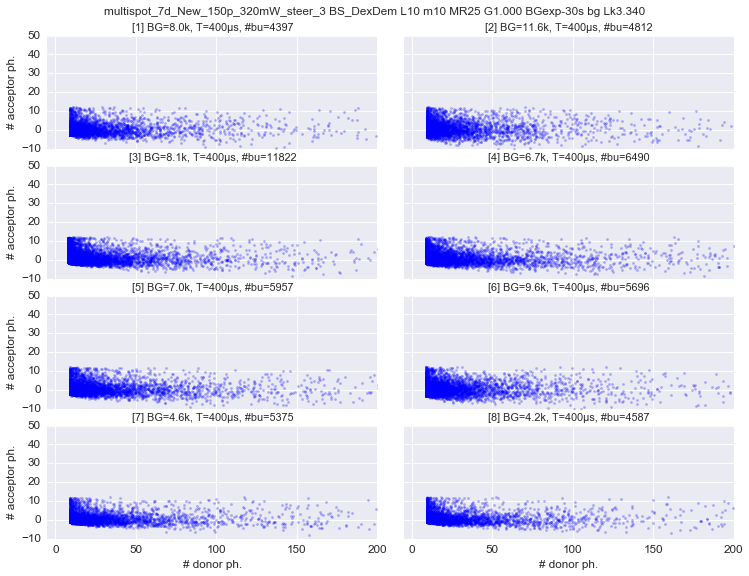

In [30]:
dplot(dxdo, scatter_da);
plt.ylim(-10, 50)

In [31]:
(nt_th_R, bw_th_R, pr_th_R,
 nt_th_R_n, bw_th_R_n, pr_th_R_n) = burst_mean_vs_th(dxdo)

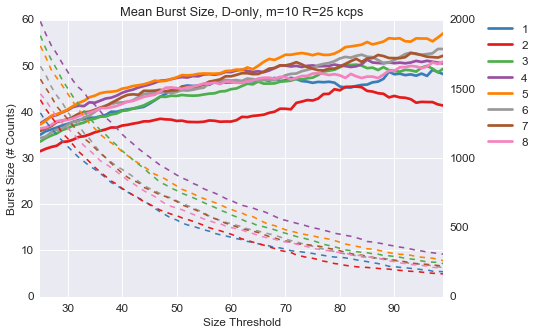

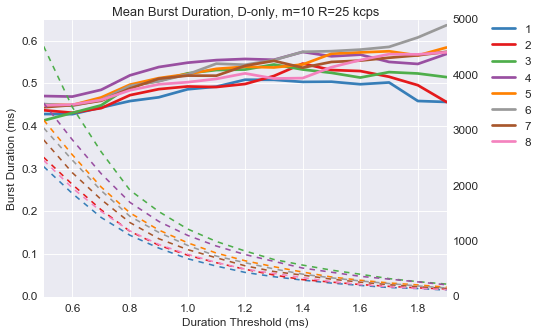

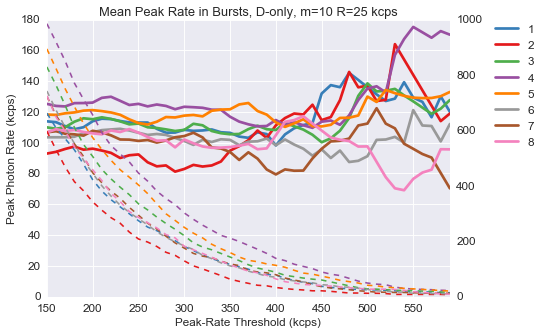

In [32]:
title = 'D-only, m=%d R=%d kcps' % (m, rate_th*1e-3)
plot_mean_size_th(nt_th_R, nt_th_R_n, title=title)
plot_mean_width_th(bw_th_R, bw_th_R_n, title=title)
plot_mean_phrate_th(pr_th_R, pr_th_R_n, title=title)

In [33]:
s_F[data_id] = nt_th_F  # burst size
s_R[data_id] = nt_th_R
w_F[data_id] = bw_th_F  # burst duration
w_R[data_id] = bw_th_R
p_F[data_id] = pr_th_F  # burst peak photon rate
p_R[data_id] = pr_th_R

# 12d sample

In [34]:
data_id = '12d'

In [35]:
dx = loader.photon_hdf5(files_dict[data_id])
dx.calc_bg(**bg_kwargs_auto)
bg1[data_id] = pd.Series([bd.mean() + ba.mean() for bd, ba in zip(dx.bg_dd, dx.bg_ad)], 
                         index=pd.Index(range(8), name='Ch'))
dx.leakage = leakage

 - Calculating BG rates ... 

[DONE]


**SBR Burst Search**

In [36]:
dx.burst_search(m=m, F=F, ph_sel=ph_sel)
dxdo = select_do(dx)

 - Performing burst search (verbose=False) ...

 - Recomputing background limits for DexDem ... 

[DONE]


 - Recomputing background limits for all ... 

[DONE]


 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [37]:
(nt_th_F, bw_th_F, pr_th_F,
 nt_th_F_n, bw_th_F_n, pr_th_F_n) = burst_mean_vs_th(dxdo)

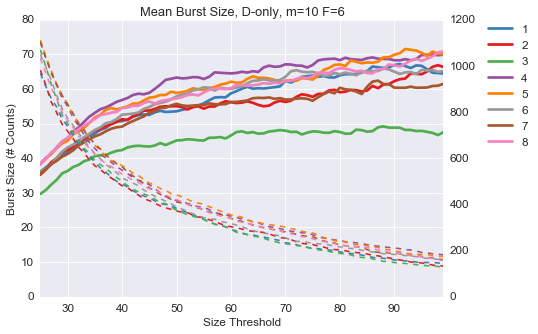

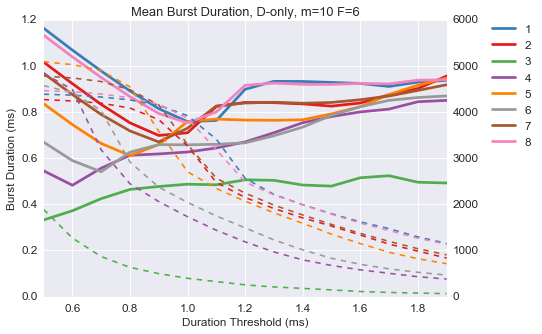

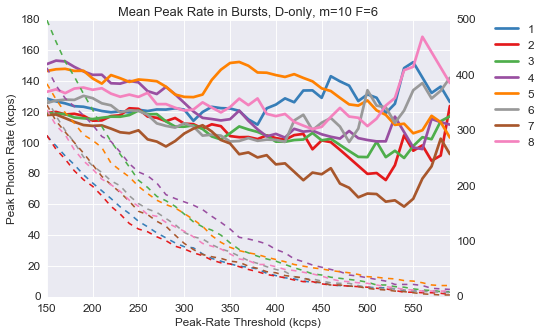

In [38]:
title = 'D-only, m=%d F=%d' % (m, F)
plot_mean_size_th(nt_th_F, nt_th_F_n, title=title)
plot_mean_width_th(bw_th_F, bw_th_F_n, title=title)
plot_mean_phrate_th(pr_th_F, pr_th_F_n, title=title)

**Fixed-rate Burst Search**

In [39]:
dx.burst_search(m=m, min_rate_cps=rate_th, ph_sel=ph_sel)
dxdo = select_do(dx)

 - Performing burst search (verbose=False) ...

 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [40]:
(nt_th_R, bw_th_R, pr_th_R,
 nt_th_R_n, bw_th_R_n, pr_th_R_n) = burst_mean_vs_th(dxdo)

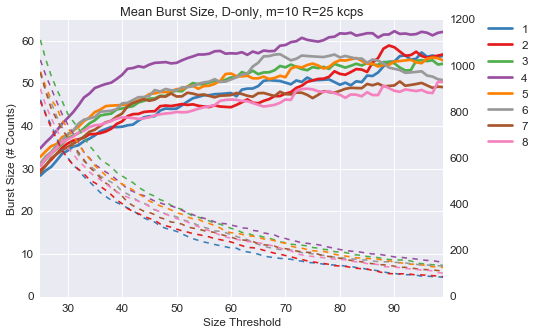

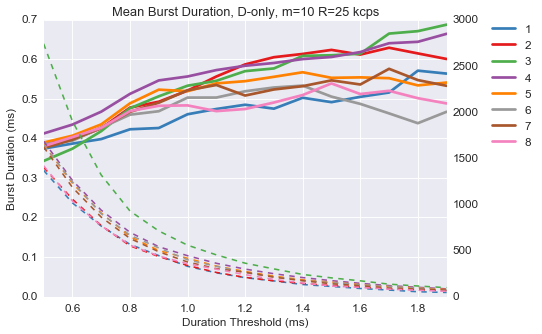

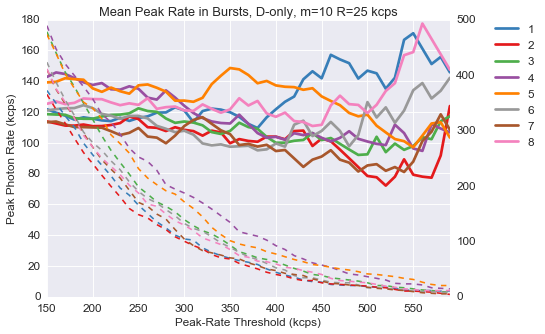

In [41]:
title = 'D-only, m=%d R=%d kcps' % (m, rate_th*1e-3)
plot_mean_size_th(nt_th_R, nt_th_R_n, title=title)
plot_mean_width_th(bw_th_R, bw_th_R_n, title=title)
plot_mean_phrate_th(pr_th_R, pr_th_R_n, title=title)

In [42]:
s_F[data_id] = nt_th_F  # burst size
s_R[data_id] = nt_th_R
w_F[data_id] = bw_th_F  # burst duration
w_R[data_id] = bw_th_R
p_F[data_id] = pr_th_F  # burst peak photon rate
p_R[data_id] = pr_th_R

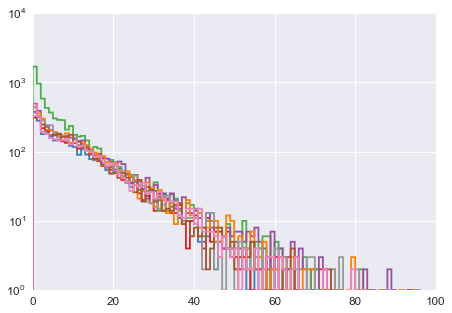

In [43]:
bursts = pd.concat([bext.burst_data(dx, ich=ich).assign(ich=ich)
                    for ich in range(8)])

kw = dict(bins = np.arange(0, 100), histtype='step', lw=2)
for ich in range(8):
    mask = bursts.ich == ich
    plt.hist(bursts.na[mask], **kw)
plt.yscale('log')

# 17d sample

In [44]:
data_id = '17d'

In [45]:
dx = loader.photon_hdf5(files_dict[data_id])
dx.calc_bg(**bg_kwargs_auto)
bg1[data_id] = pd.Series([bd.mean() + ba.mean() for bd, ba in zip(dx.bg_dd, dx.bg_ad)], 
                         index=pd.Index(range(8), name='Ch'))
dx.leakage = leakage

 - Calculating BG rates ... 

[DONE]


**SBR Burst Search**

In [46]:
dx.burst_search(m=m, F=F, ph_sel=ph_sel)
dxdo = select_do(dx)

 - Performing burst search (verbose=False) ...

 - Recomputing background limits for DexDem ... 

[DONE]


 - Recomputing background limits for all ... 

[DONE]


 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [47]:
(nt_th_F, bw_th_F, pr_th_F,
 nt_th_F_n, bw_th_F_n, pr_th_F_n) = burst_mean_vs_th(dxdo)

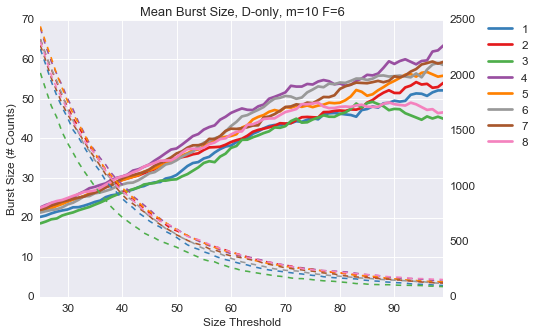

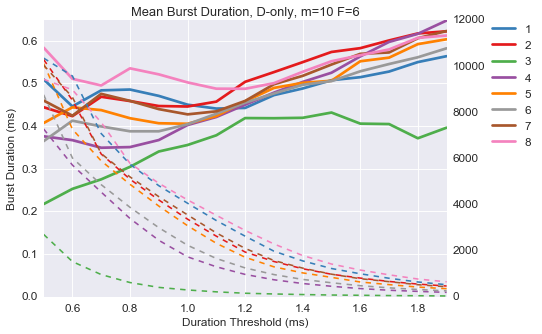

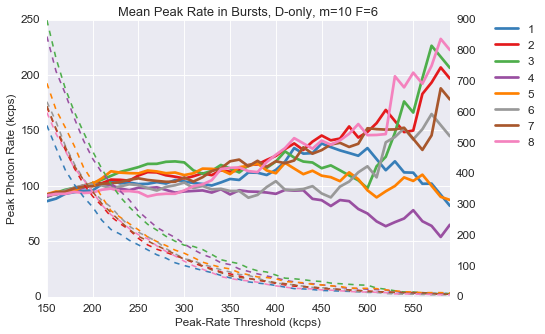

In [48]:
title = 'D-only, m=%d F=%d' % (m, F)
plot_mean_size_th(nt_th_F, nt_th_F_n, title=title)
plot_mean_width_th(bw_th_F, bw_th_F_n, title=title)
plot_mean_phrate_th(pr_th_F, pr_th_F_n, title=title)

**Fixed-rate Burst Search**

In [49]:
dx.burst_search(m=m, min_rate_cps=rate_th, ph_sel=ph_sel)
dxdo = select_do(dx)

 - Performing burst search (verbose=False) ...

 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [50]:
(nt_th_R, bw_th_R, pr_th_R,
 nt_th_R_n, bw_th_R_n, pr_th_R_n) = burst_mean_vs_th(dxdo)

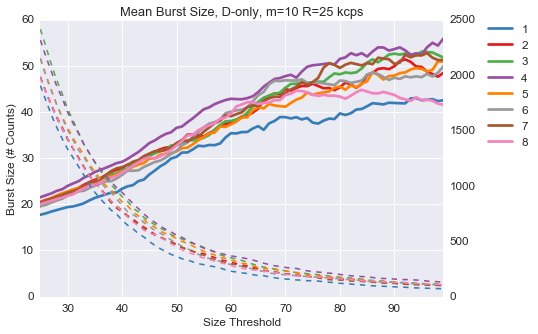

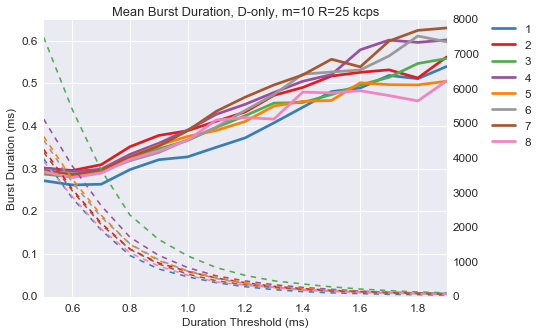

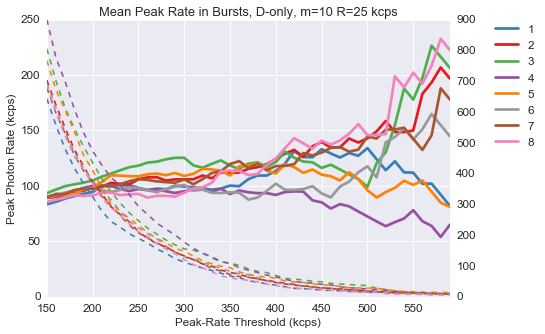

In [51]:
title = 'D-only, m=%d R=%d kcps' % (m, rate_th*1e-3)
plot_mean_size_th(nt_th_R, nt_th_R_n, title=title)
plot_mean_width_th(bw_th_R, bw_th_R_n, title=title)
plot_mean_phrate_th(pr_th_R, pr_th_R_n, title=title)

In [52]:
s_F[data_id] = nt_th_F  # burst size
s_R[data_id] = nt_th_R
w_F[data_id] = bw_th_F  # burst duration
w_R[data_id] = bw_th_R
p_F[data_id] = pr_th_F  # burst peak photon rate
p_R[data_id] = pr_th_R

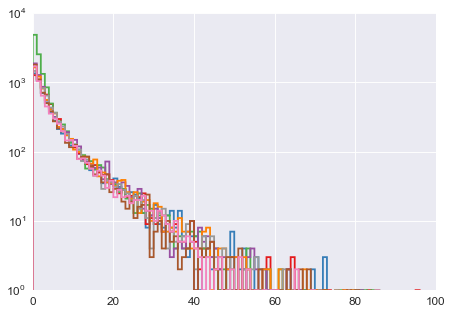

In [53]:
bursts = pd.concat([bext.burst_data(dx, ich=ich).assign(ich=ich)
                    for ich in range(8)])

kw = dict(bins = np.arange(0, 100), histtype='step', lw=2)
for ich in range(8):
    mask = bursts.ich == ich
    plt.hist(bursts.na[mask], **kw)
plt.yscale('log')

# 22d sample

In [54]:
data_id = '22d'

In [55]:
dx = loader.photon_hdf5(files_dict[data_id])
dx.calc_bg(**bg_kwargs_auto)
bg1[data_id] = pd.Series([bd.mean() + ba.mean() for bd, ba in zip(dx.bg_dd, dx.bg_ad)], 
                         index=pd.Index(range(8), name='Ch'))
dx.leakage = leakage

 - Calculating BG rates ... 

[DONE]


**SBR Burst Search**

In [56]:
dx.burst_search(m=m, F=F, ph_sel=ph_sel)
dxdo = select_do(dx)

 - Performing burst search (verbose=False) ...

 - Recomputing background limits for DexDem ... 

[DONE]


 - Recomputing background limits for all ... 

[DONE]


 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [57]:
(nt_th_F, bw_th_F, pr_th_F,
 nt_th_F_n, bw_th_F_n, pr_th_F_n) = burst_mean_vs_th(dxdo)

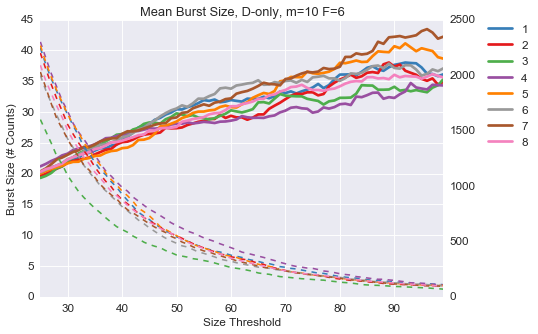

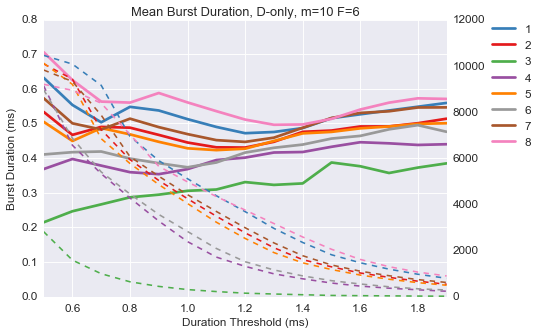

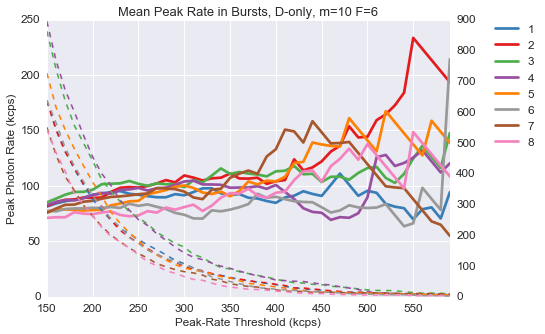

In [58]:
title = 'D-only, m=%d F=%d' % (m, F)
plot_mean_size_th(nt_th_F, nt_th_F_n, title=title)
plot_mean_width_th(bw_th_F, bw_th_F_n, title=title)
plot_mean_phrate_th(pr_th_F, pr_th_F_n, title=title)

**Fixed-rate Burst Search**

In [59]:
dx.burst_search(m=m, min_rate_cps=rate_th, ph_sel=ph_sel)
dxdo = select_do(dx)

 - Performing burst search (verbose=False) ...

 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [60]:
(nt_th_R, bw_th_R, pr_th_R,
 nt_th_R_n, bw_th_R_n, pr_th_R_n) = burst_mean_vs_th(dxdo)

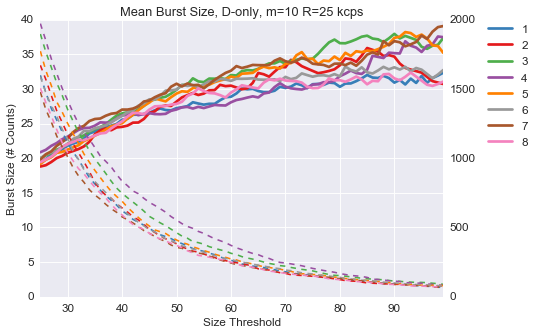

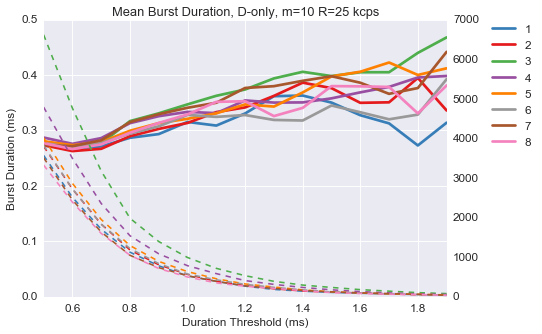

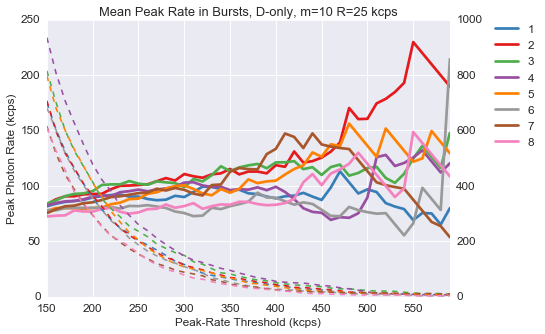

In [61]:
title = 'D-only, m=%d R=%d kcps' % (m, rate_th*1e-3)
plot_mean_size_th(nt_th_R, nt_th_R_n, title=title)
plot_mean_width_th(bw_th_R, bw_th_R_n, title=title)
plot_mean_phrate_th(pr_th_R, pr_th_R_n, title=title)

In [62]:
s_F[data_id] = nt_th_F  # burst size
s_R[data_id] = nt_th_R
w_F[data_id] = bw_th_F  # burst duration
w_R[data_id] = bw_th_R
p_F[data_id] = pr_th_F  # burst peak photon rate
p_R[data_id] = pr_th_R

# 27d sample

In [63]:
data_id = '27d'

In [64]:
dx = loader.photon_hdf5(files_dict[data_id])
dx.calc_bg(**bg_kwargs_auto)
bg1[data_id] = pd.Series([bd.mean() + ba.mean() for bd, ba in zip(dx.bg_dd, dx.bg_ad)], 
                         index=pd.Index(range(8), name='Ch'))
dx.leakage = leakage

 - Calculating BG rates ... 

[DONE]


**SBR Burst Search**

In [65]:
dx.burst_search(m=m, F=F, ph_sel=ph_sel)
dxdo = select_do(dx)

 - Performing burst search (verbose=False) ...

 - Recomputing background limits for DexDem ... 

[DONE]


 - Recomputing background limits for all ... 

[DONE]


 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [66]:
(nt_th_F, bw_th_F, pr_th_F,
 nt_th_F_n, bw_th_F_n, pr_th_F_n) = burst_mean_vs_th(dxdo)

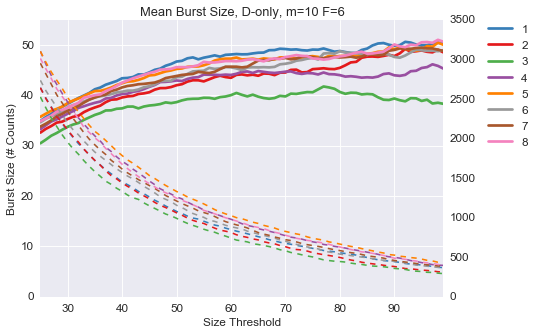

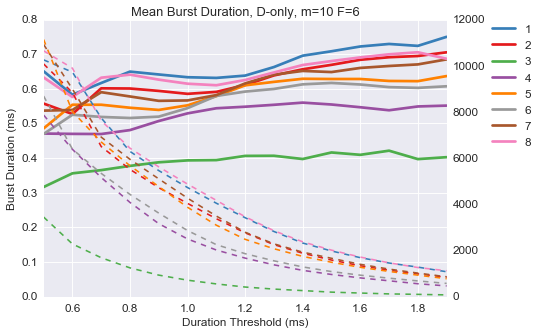

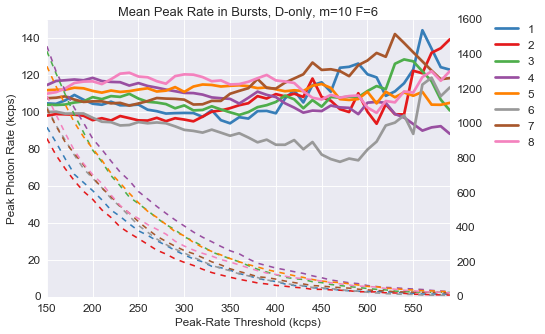

In [67]:
title = 'D-only, m=%d F=%d' % (m, F)
plot_mean_size_th(nt_th_F, nt_th_F_n, title=title)
plot_mean_width_th(bw_th_F, bw_th_F_n, title=title)
plot_mean_phrate_th(pr_th_F, pr_th_F_n, title=title)

**Fixed-rate Burst Search**

In [68]:
dx.burst_search(m=m, min_rate_cps=rate_th, ph_sel=ph_sel)
dxdo = select_do(dx)

 - Performing burst search (verbose=False) ...

 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [69]:
(nt_th_R, bw_th_R, pr_th_R,
 nt_th_R_n, bw_th_R_n, pr_th_R_n) = burst_mean_vs_th(dxdo)

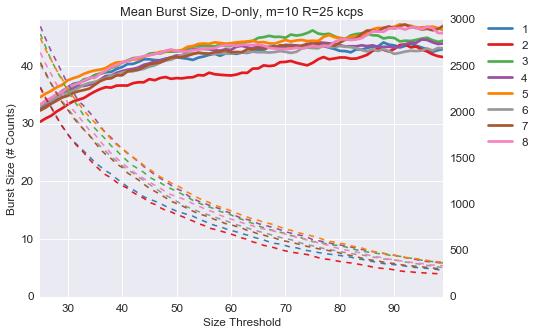

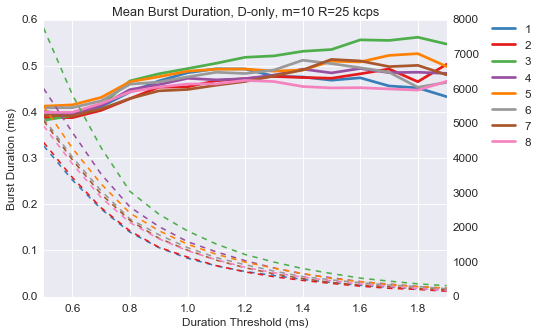

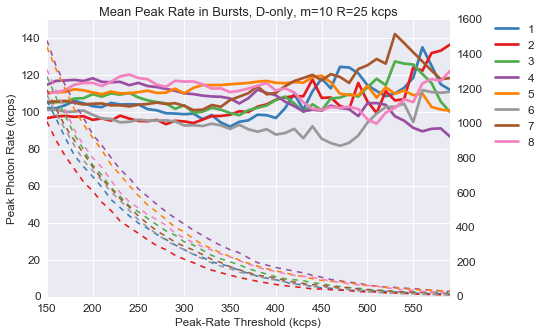

In [70]:
title = 'D-only, m=%d R=%d kcps' % (m, rate_th*1e-3)
plot_mean_size_th(nt_th_R, nt_th_R_n, title=title)
plot_mean_width_th(bw_th_R, bw_th_R_n, title=title)
plot_mean_phrate_th(pr_th_R, pr_th_R_n, title=title)

In [71]:
s_F[data_id] = nt_th_F  # burst size
s_R[data_id] = nt_th_R
w_F[data_id] = bw_th_F  # burst duration
w_R[data_id] = bw_th_R
p_F[data_id] = pr_th_F  # burst peak photon rate
p_R[data_id] = pr_th_R

# D-only sample

In [72]:
data_id = 'DO'

In [73]:
dx = loader.photon_hdf5(files_dict[data_id])
dx.calc_bg(**bg_kwargs_auto)
bg1[data_id] = pd.Series([bd.mean() + ba.mean() for bd, ba in zip(dx.bg_dd, dx.bg_ad)], 
                         index=pd.Index(range(8), name='Ch'))
dx.leakage = leakage

 - Calculating BG rates ... 

[DONE]


**SBR Burst Search**

In [74]:
dx.burst_search(m=m, F=F, ph_sel=ph_sel)
dxdo = dx

 - Performing burst search (verbose=False) ...

 - Recomputing background limits for DexDem ... 

[DONE]


 - Recomputing background limits for all ... 

[DONE]


 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [75]:
(nt_th_F, bw_th_F, pr_th_F,
 nt_th_F_n, bw_th_F_n, pr_th_F_n) = burst_mean_vs_th(dxdo)

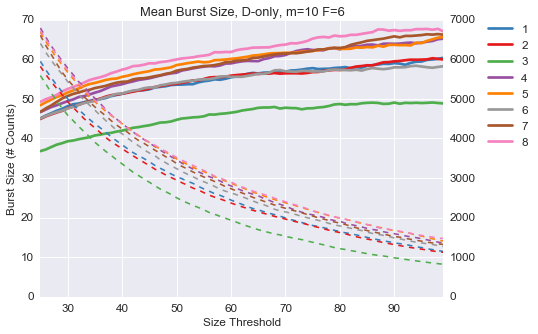

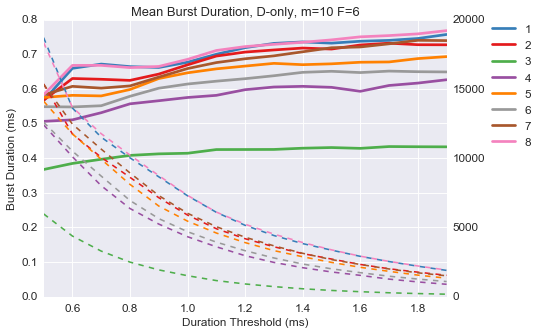

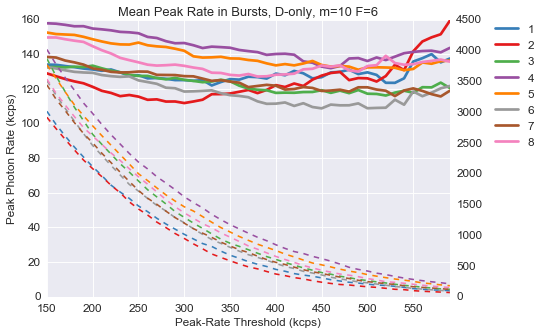

In [76]:
title = 'D-only, m=%d F=%d' % (m, F)
plot_mean_size_th(nt_th_F, nt_th_F_n, title=title)
plot_mean_width_th(bw_th_F, bw_th_F_n, title=title)
plot_mean_phrate_th(pr_th_F, pr_th_F_n, title=title)

**Fixed-rate Burst Search**

In [77]:
dx.burst_search(m=m, min_rate_cps=rate_th, ph_sel=ph_sel)
dxdo = dx

 - Performing burst search (verbose=False) ...

 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


In [78]:
(nt_th_R, bw_th_R, pr_th_R,
 nt_th_R_n, bw_th_R_n, pr_th_R_n) = burst_mean_vs_th(dxdo)

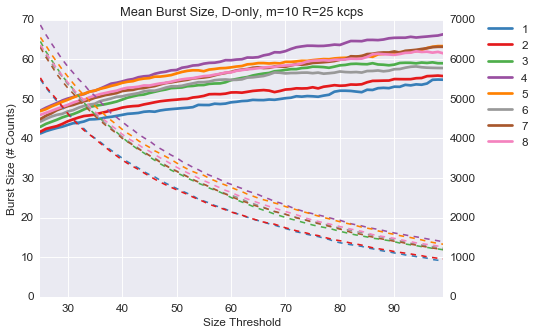

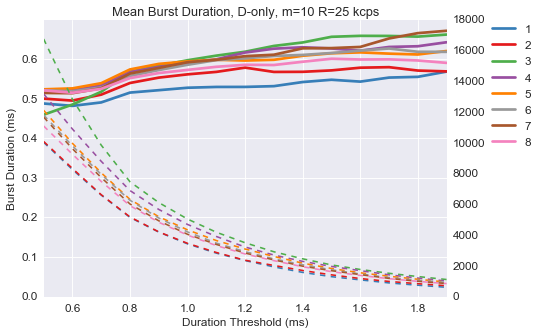

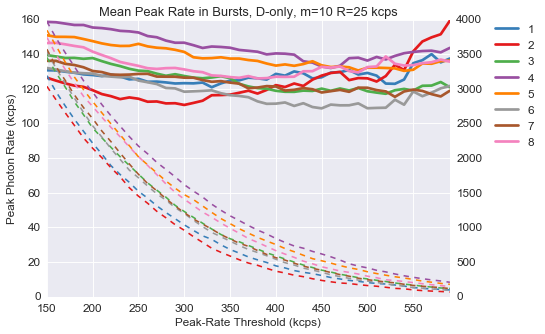

In [79]:
title = 'D-only, m=%d R=%d kcps' % (m, rate_th*1e-3)
plot_mean_size_th(nt_th_R, nt_th_R_n, title=title)
plot_mean_width_th(bw_th_R, bw_th_R_n, title=title)
plot_mean_phrate_th(pr_th_R, pr_th_R_n, title=title)

In [80]:
s_F[data_id] = nt_th_F  # burst size
s_R[data_id] = nt_th_R
w_F[data_id] = bw_th_F  # burst duration
w_R[data_id] = bw_th_R
p_F[data_id] = pr_th_F  # burst peak photon rate
p_R[data_id] = pr_th_R

# Summary

In [81]:
%config InlineBackend.figure_format='retina'  # for hi-dpi displays
sns.set_style('whitegrid')

## Burst size vs BG

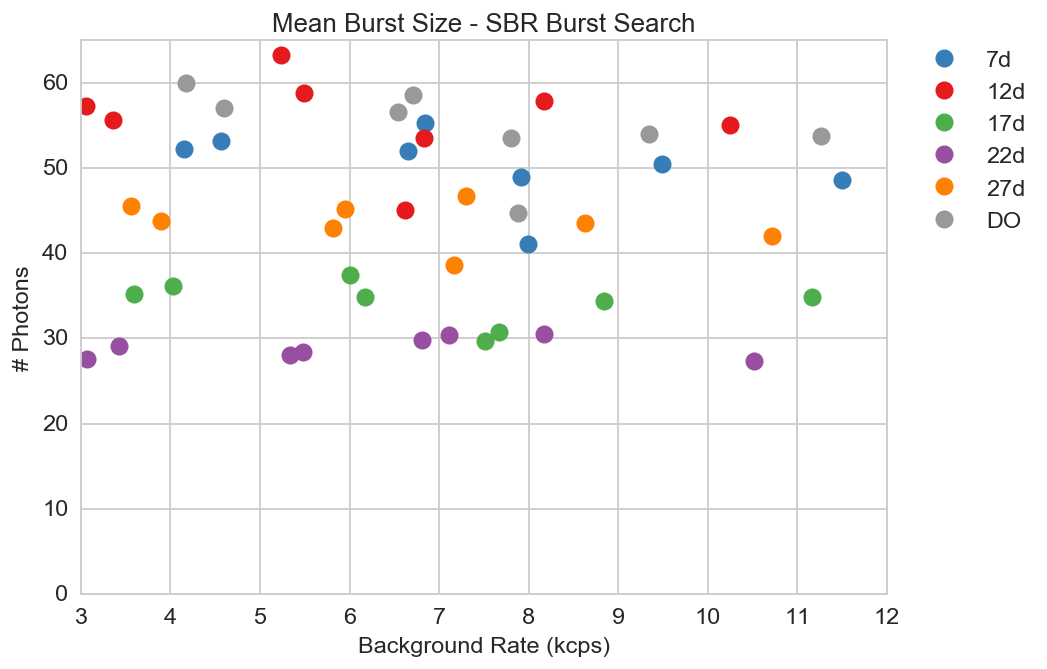

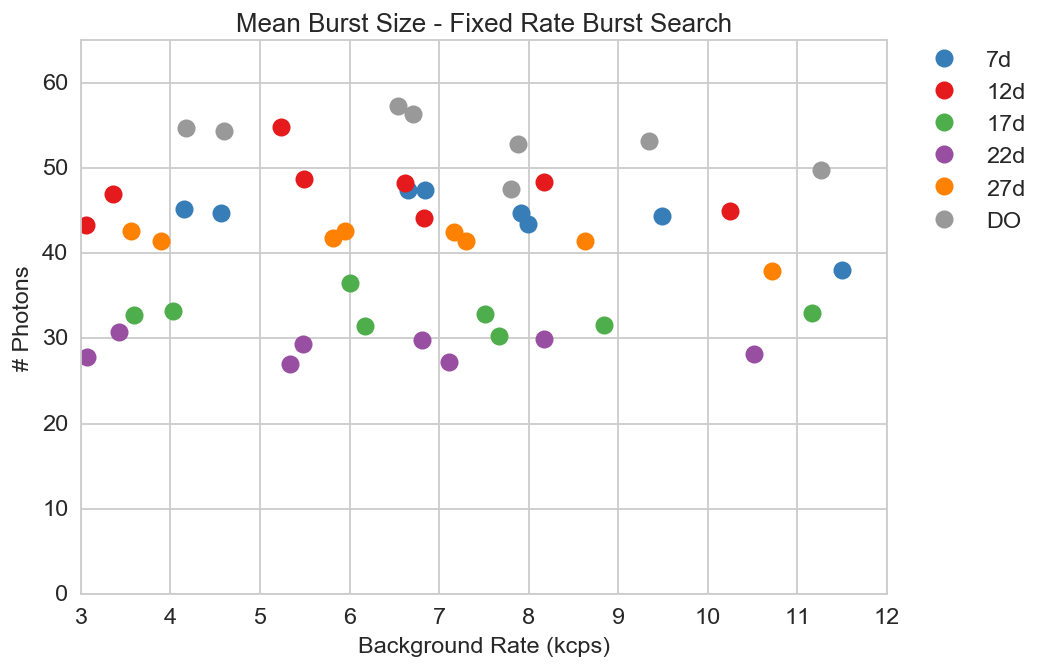

In [82]:
for did in labels:
    plt.plot(bg1[did]*1e-3, s_F[did].loc[nt_th1].T, 'o', ms=10, label=did)
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.);
plt.ylim(0, 65)
plt.xlabel('Background Rate (kcps)')
plt.ylabel('# Photons')
plt.title('Mean Burst Size - SBR Burst Search');

plt.figure()
for did in labels:
    plt.plot(bg1[did]*1e-3, s_R[did].loc[nt_th1].T, 'o', ms=10, label=did)
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0);
plt.ylim(0, 65)
plt.xlabel('Background Rate (kcps)')
plt.ylabel('# Photons')
plt.title('Mean Burst Size - Fixed Rate Burst Search');

## Burst duration  vs BG

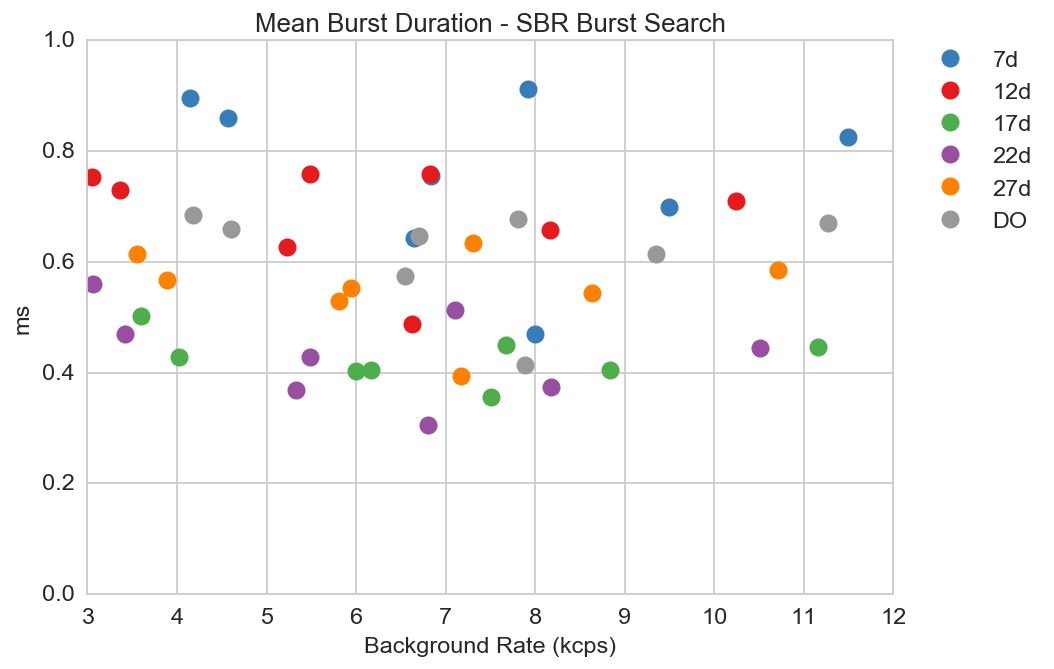

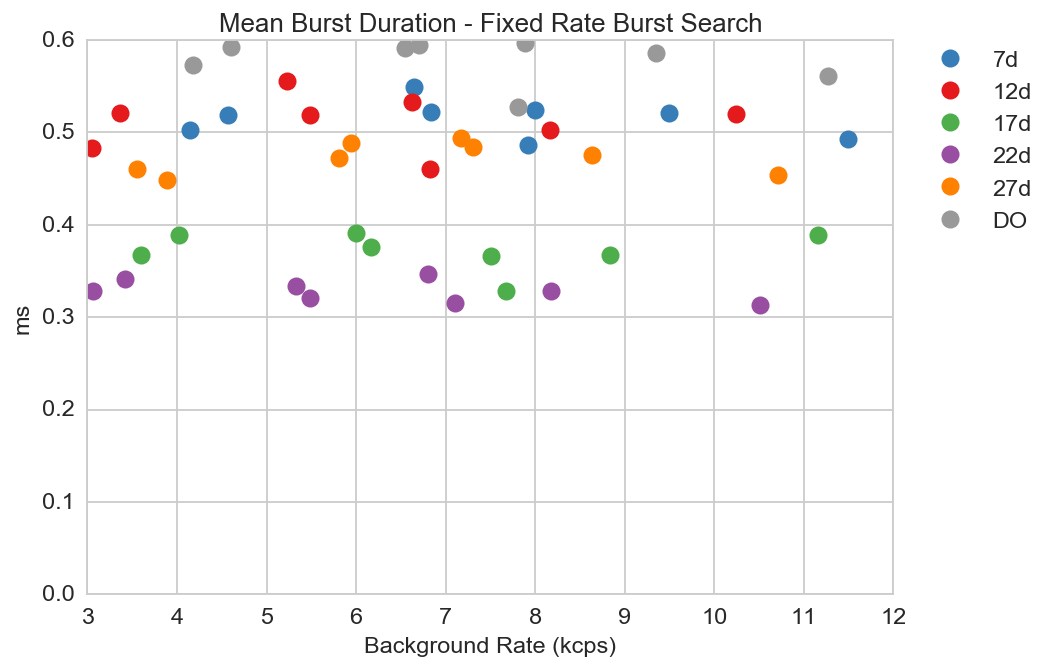

In [83]:
for did in labels:
    plt.plot(bg1[did]*1e-3, w_F[did].loc[bw_th1].T, 'o', ms=10, label=did)
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.);
plt.ylim(0)
plt.xlabel('Background Rate (kcps)')
plt.ylabel('ms')
plt.title('Mean Burst Duration - SBR Burst Search');

plt.figure()
for did in labels:
    plt.plot(bg1[did]*1e-3, w_R[did].loc[bw_th1].T, 'o', ms=10, label=did)
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0);
plt.ylim(0)
plt.xlabel('Background Rate (kcps)')
plt.ylabel('ms')
plt.title('Mean Burst Duration - Fixed Rate Burst Search');

## Peak Photon rate  vs BG

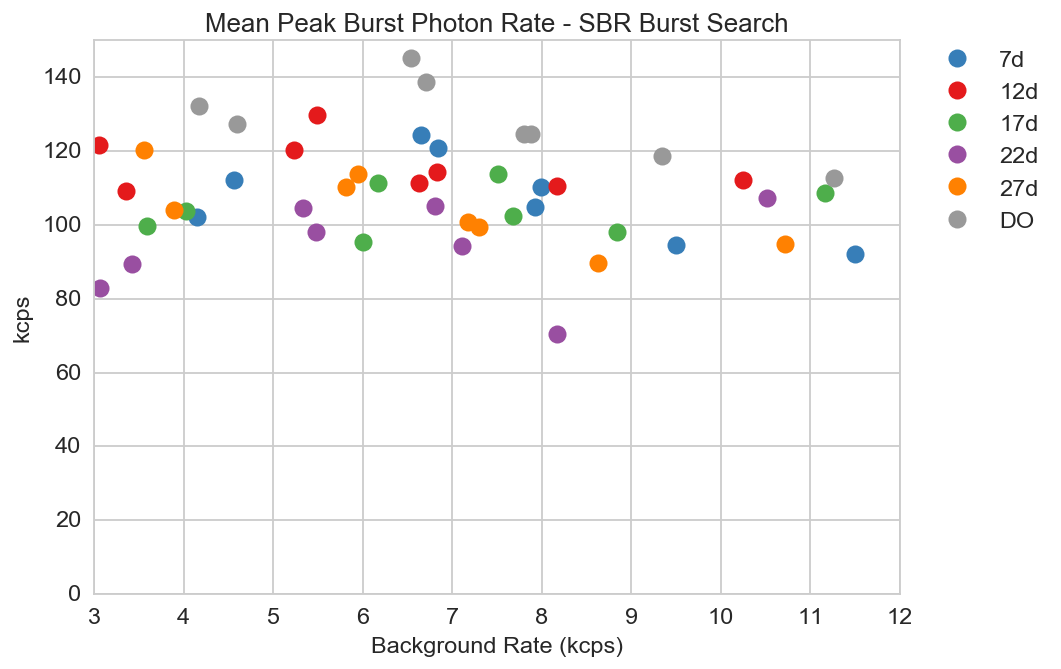

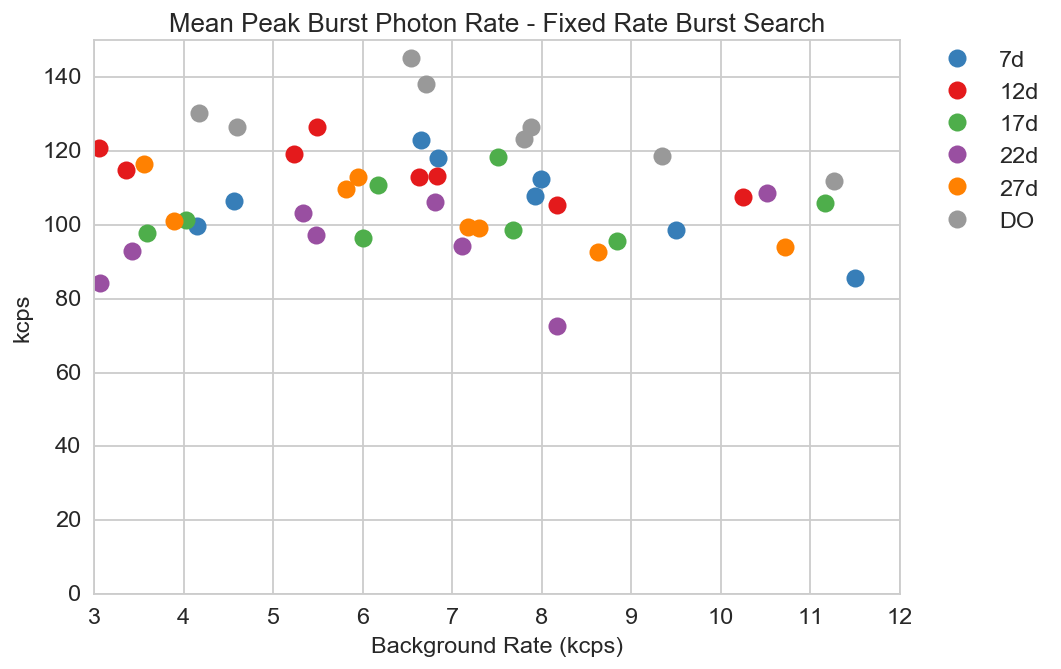

In [84]:
for did in labels:
    plt.plot(bg1[did]*1e-3, p_F[did].loc[pr_th1].T, 'o', ms=10, label=did)
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.);
plt.ylim(0)
plt.xlabel('Background Rate (kcps)');
plt.ylabel('kcps')
plt.title('Mean Peak Burst Photon Rate - SBR Burst Search')

plt.figure()
for did in labels:
    plt.plot(bg1[did]*1e-3, p_R[did].loc[pr_th1].T, 'o', ms=10, label=did)
plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0);
plt.ylim(0)
plt.xlabel('Background Rate (kcps)');
plt.ylabel('kcps');
plt.title('Mean Peak Burst Photon Rate - Fixed Rate Burst Search');

# Profiles vs spot

## Burst size vs CH

In [85]:
s_F_th1 = pd.concat([s_F[did].loc[nt_th1] for did in labels], 1)
s_F_th1.columns = labels
s_R_th1 = pd.concat([s_R[did].loc[nt_th1] for did in labels], 1)
s_R_th1.columns = labels

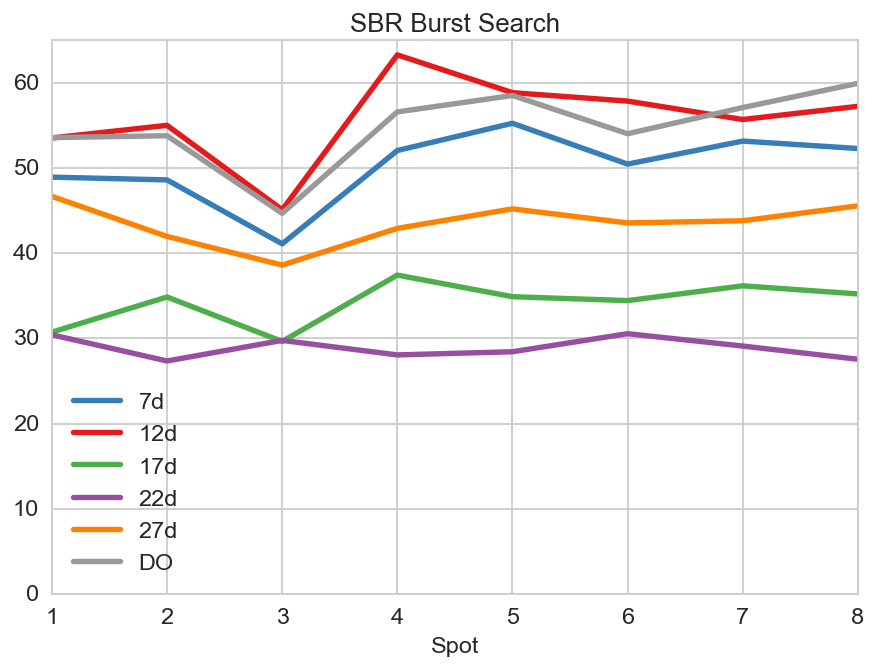

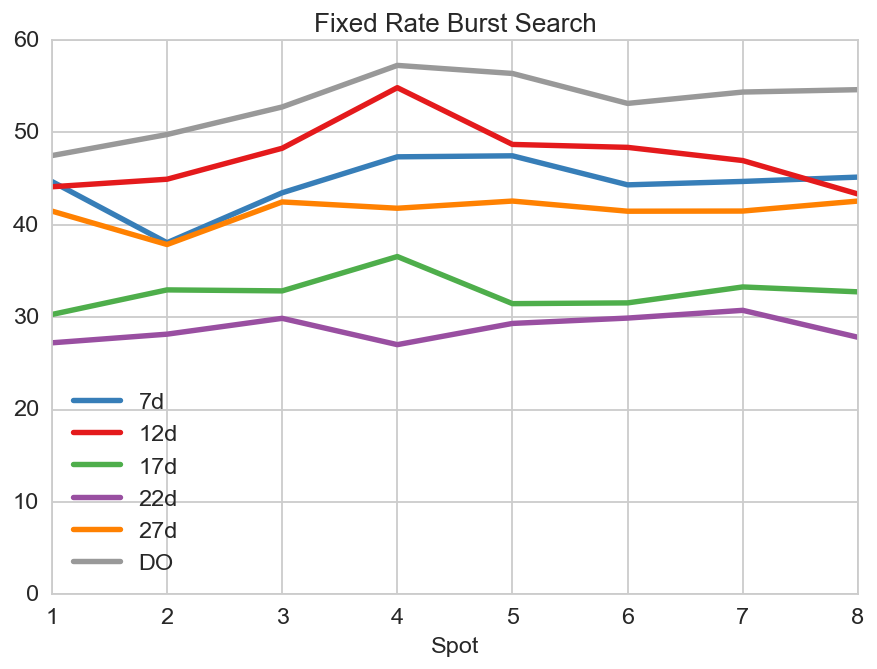

In [86]:
s_F_th1.plot(lw=3, title='SBR Burst Search')
plt.ylim(0);

s_R_th1.plot(lw=3, title='Fixed Rate Burst Search')
plt.ylim(0);

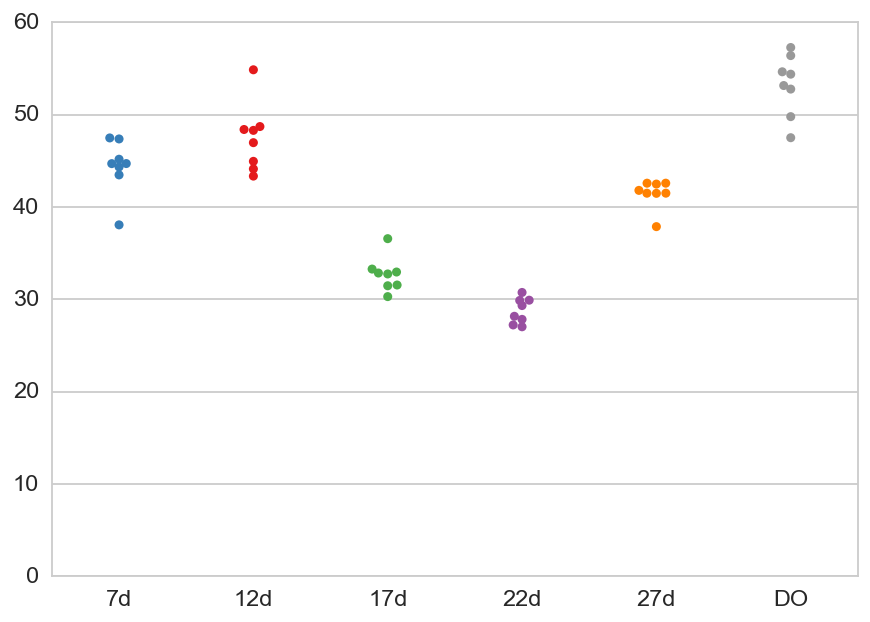

In [87]:
sns.swarmplot(data=s_R_th1);
plt.ylim(0);

## Burst Duration vs CH

In [88]:
w_F_th1 = pd.concat([w_F[did].loc[bw_th1] for did in labels], 1)
w_F_th1.columns = labels
w_R_th1 = pd.concat([w_R[did].loc[bw_th1] for did in labels], 1)
w_R_th1.columns = labels

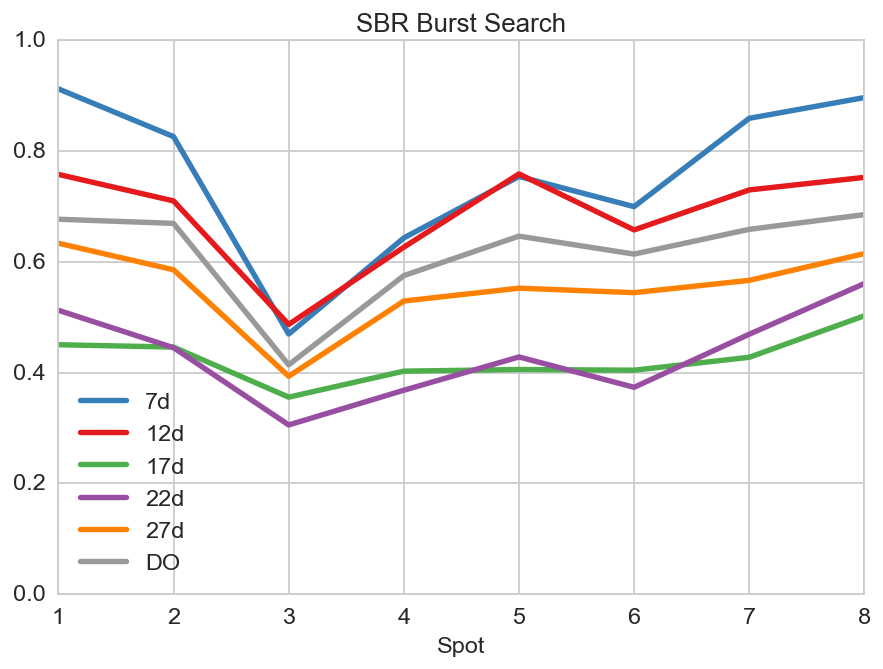

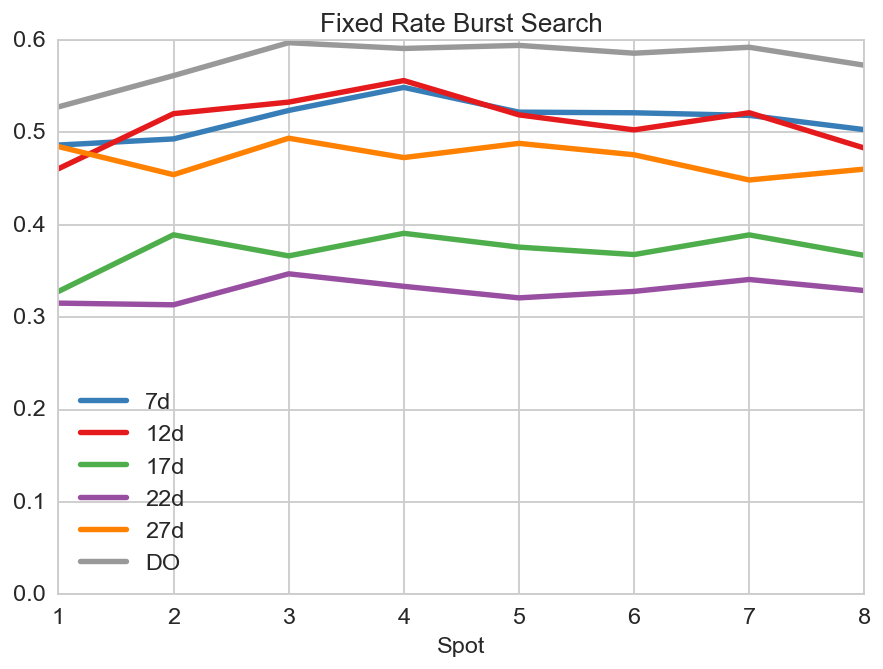

In [89]:
w_F_th1.plot(lw=3, title='SBR Burst Search')
plt.ylim(0);
w_R_th1.plot(lw=3, title='Fixed Rate Burst Search')
plt.ylim(0);

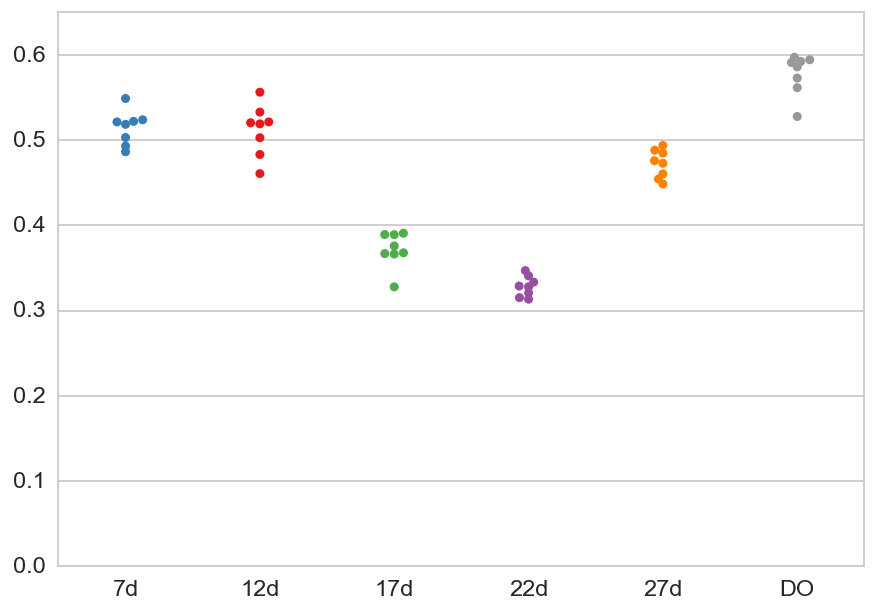

In [90]:
sns.swarmplot(data=w_R_th1);
plt.ylim(0);

## Peak Photon Rate vs CH

In [91]:
p_F_th1 = pd.concat([p_F[did].loc[pr_th1] for did in labels], 1)
p_F_th1.columns = labels
p_R_th1 = pd.concat([p_R[did].loc[pr_th1] for did in labels], 1)
p_R_th1.columns = labels

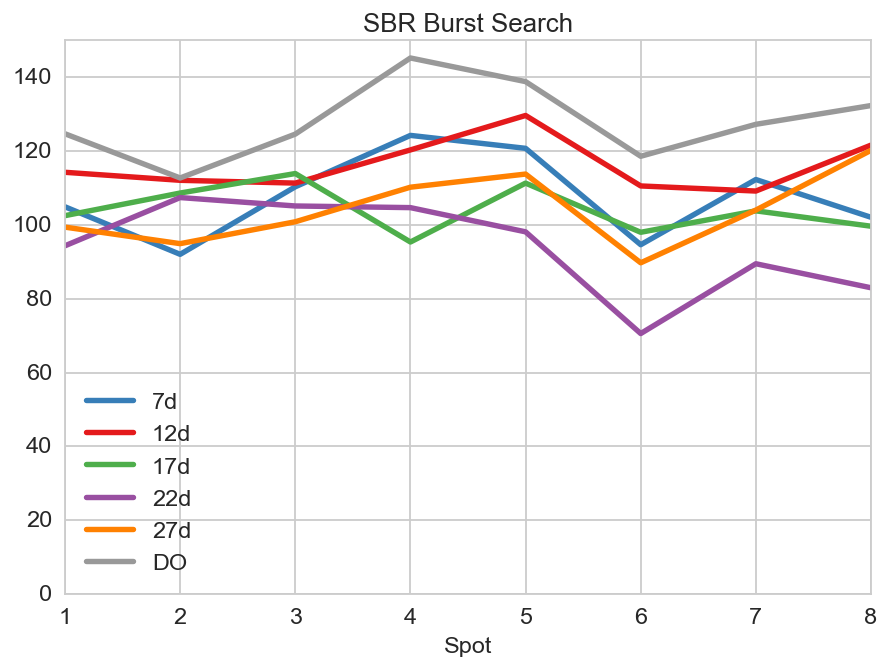

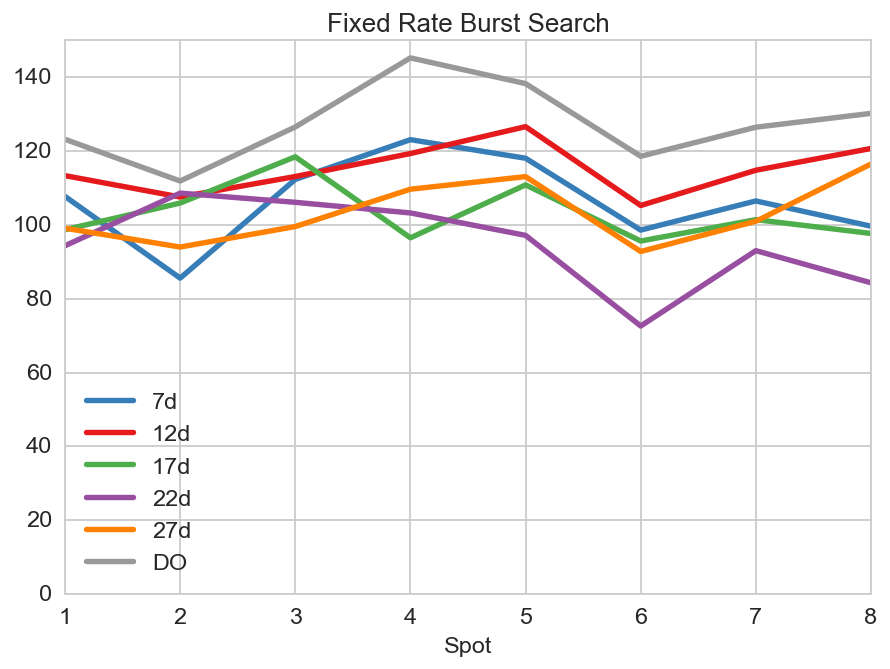

In [92]:
p_F_th1.plot(lw=3, title='SBR Burst Search')
plt.ylim(0);
p_R_th1.plot(lw=3, title='Fixed Rate Burst Search')
plt.ylim(0);

In [93]:
Th_pr

array([150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270,
       280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400,
       410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530,
       540, 550, 560, 570, 580, 590])

(0, 150.0)

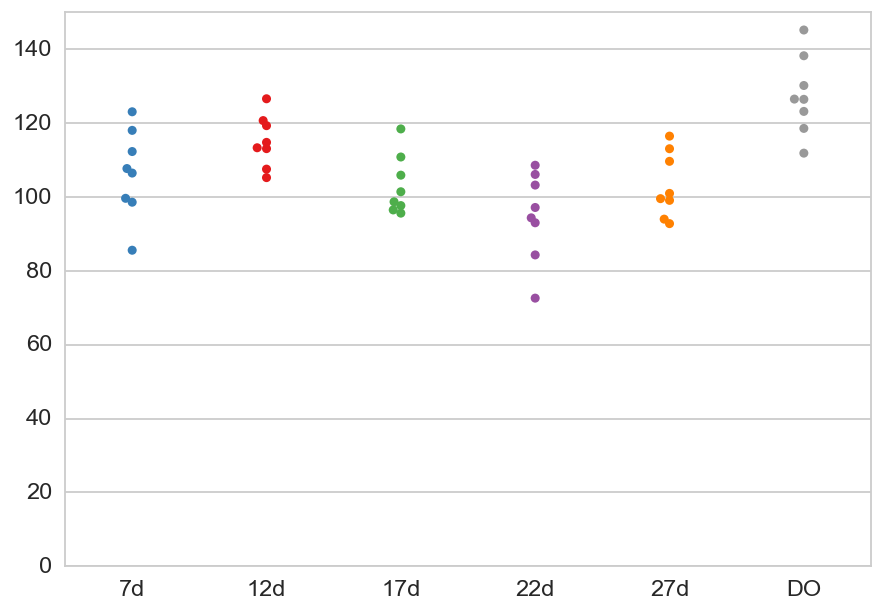

In [94]:
sns.swarmplot(data=p_R_th1);
plt.ylim(0)

# Burst Means vs Spot

In [95]:
sns.set(font_scale=1.4, palette=colors)
sns.set_style('ticks')

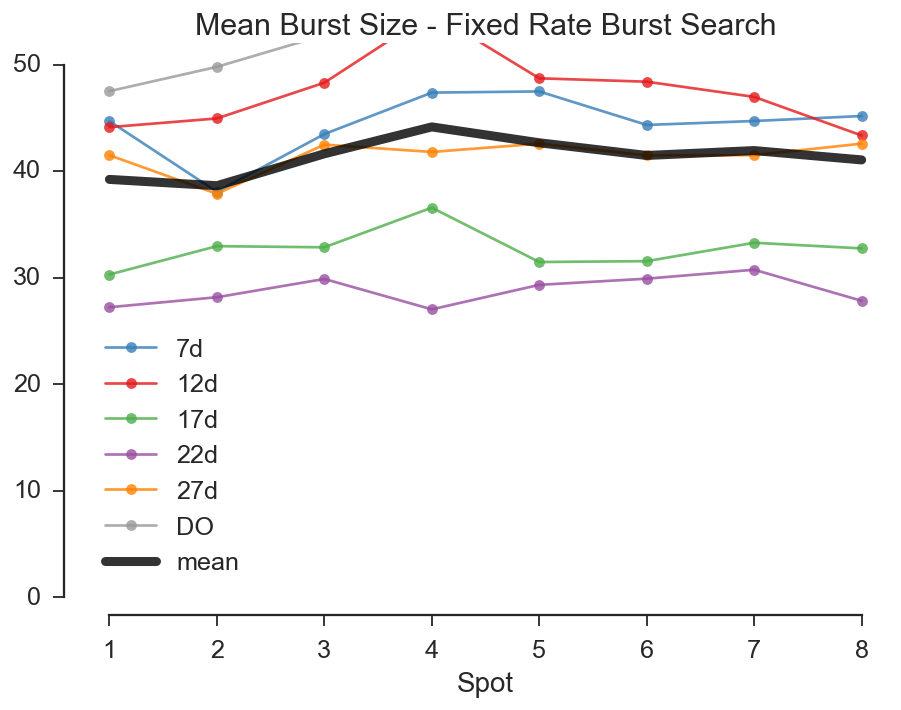

In [96]:
s_R_th1.plot(lw=1.5, marker='o', ms=6, alpha=0.8, 
             title='Mean Burst Size - Fixed Rate Burst Search')
s_R_th1.mean(1).plot(lw=5, color='k', alpha=0.8, label='mean')
plt.legend(loc=3)
plt.xlim(.75, 8.25)
plt.ylim(0, 52)
sns.despine(offset=10, trim=True)

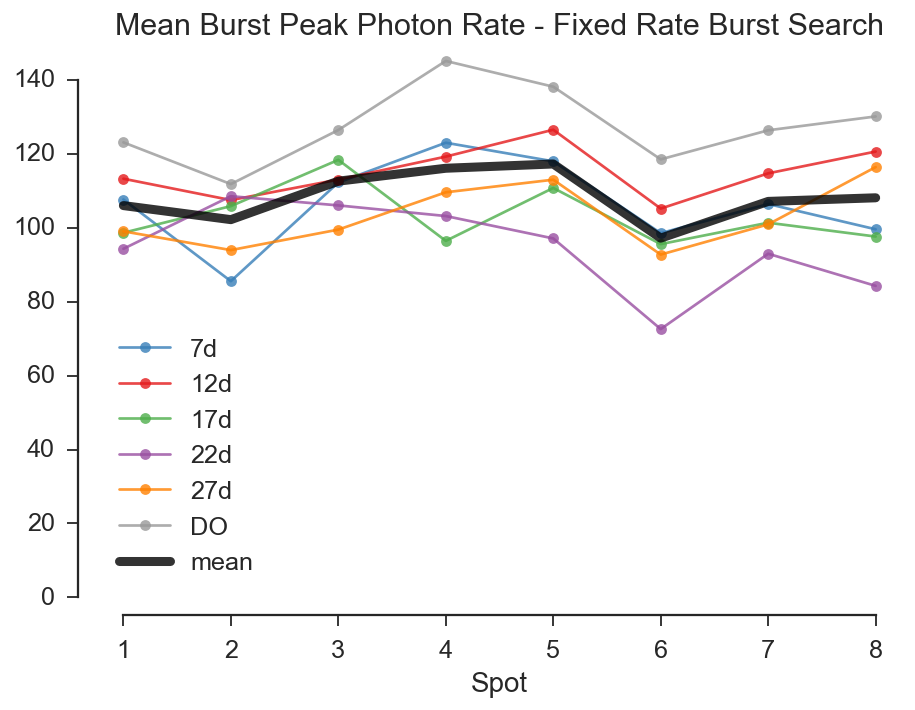

In [97]:
p_R_th1.plot(lw=1.5, marker='o', ms=6, alpha=0.8, 
             title='Mean Burst Peak Photon Rate - Fixed Rate Burst Search')
p_R_th1.mean(1).plot(lw=5, color='k', alpha=0.8, label='mean')
plt.legend(loc=3)
plt.xlim(.75, 8.25)
plt.ylim(0)
sns.despine(offset=10, trim=True)

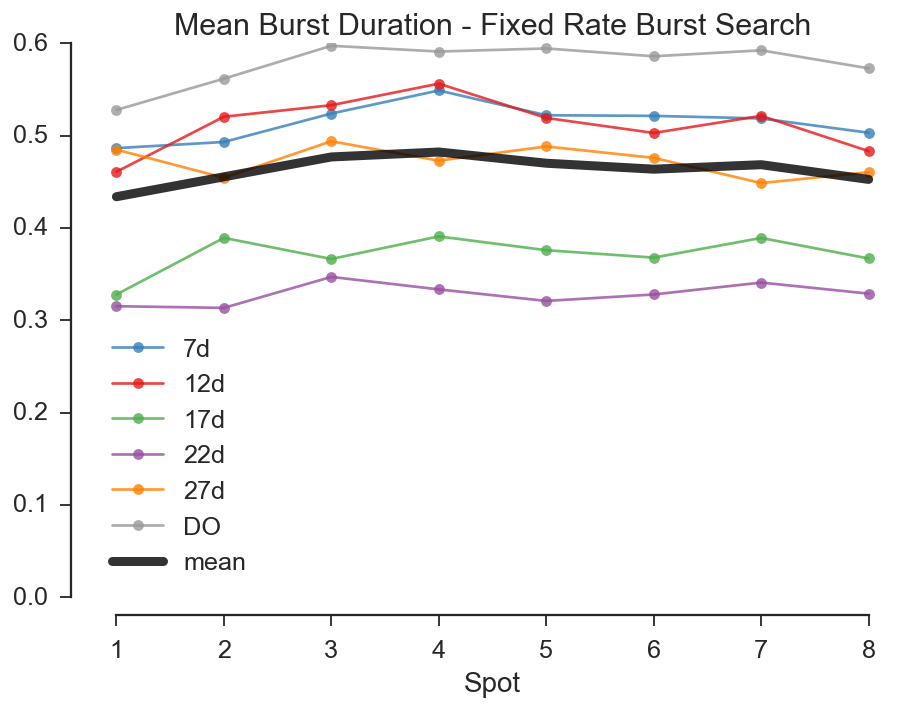

In [98]:
w_R_th1.plot(lw=1.5, marker='o', ms=6, alpha=0.8, 
             title='Mean Burst Duration - Fixed Rate Burst Search')
w_R_th1.mean(1).plot(lw=5, color='k', alpha=0.8, label='mean')
plt.legend(loc=3)
plt.xlim(.75, 8.25)
plt.ylim(0)
sns.despine(offset=10, trim=True)

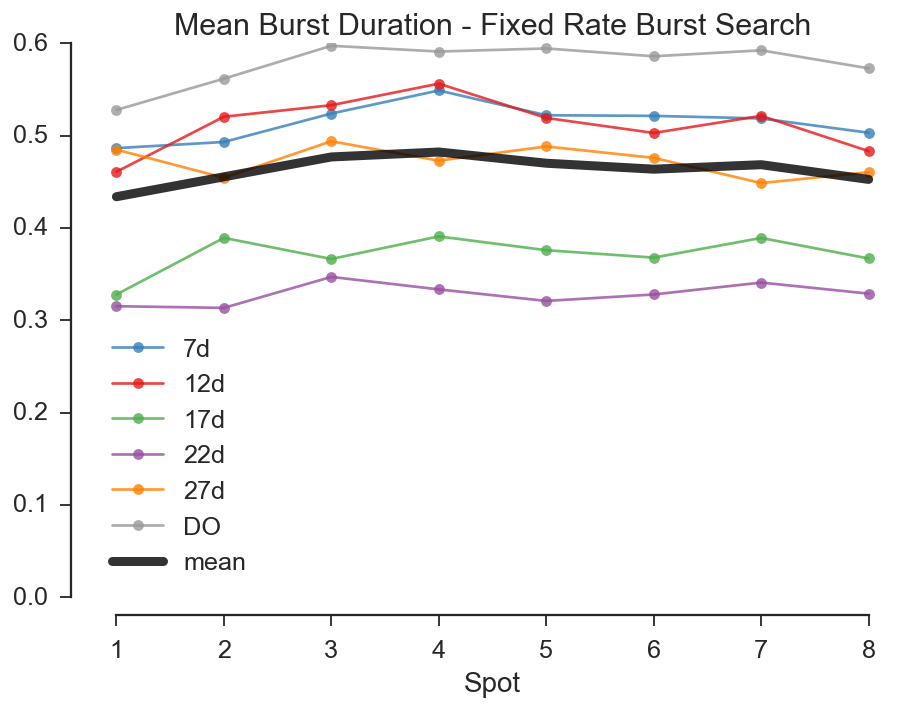

In [99]:
w_R_th1.plot(lw=1.5, marker='o', ms=6, alpha=0.8, 
             title='Mean Burst Duration - Fixed Rate Burst Search')
w_R_th1.mean(1).plot(lw=5, color='k', alpha=0.8, label='mean')
plt.legend(loc=3)
plt.xlim(.75, 8.25)
plt.ylim(0)
sns.despine(offset=10, trim=True)

In [100]:
sns.set(font_scale=1.6, palette=colors, style='ticks')

'8spot 5-dsDNA samples burst-stats vs ch F=6, R=25kcps lk=3.3 na=[-12,12] DexDem nt1=50 w1=1.0ms p1=310kcps.png'

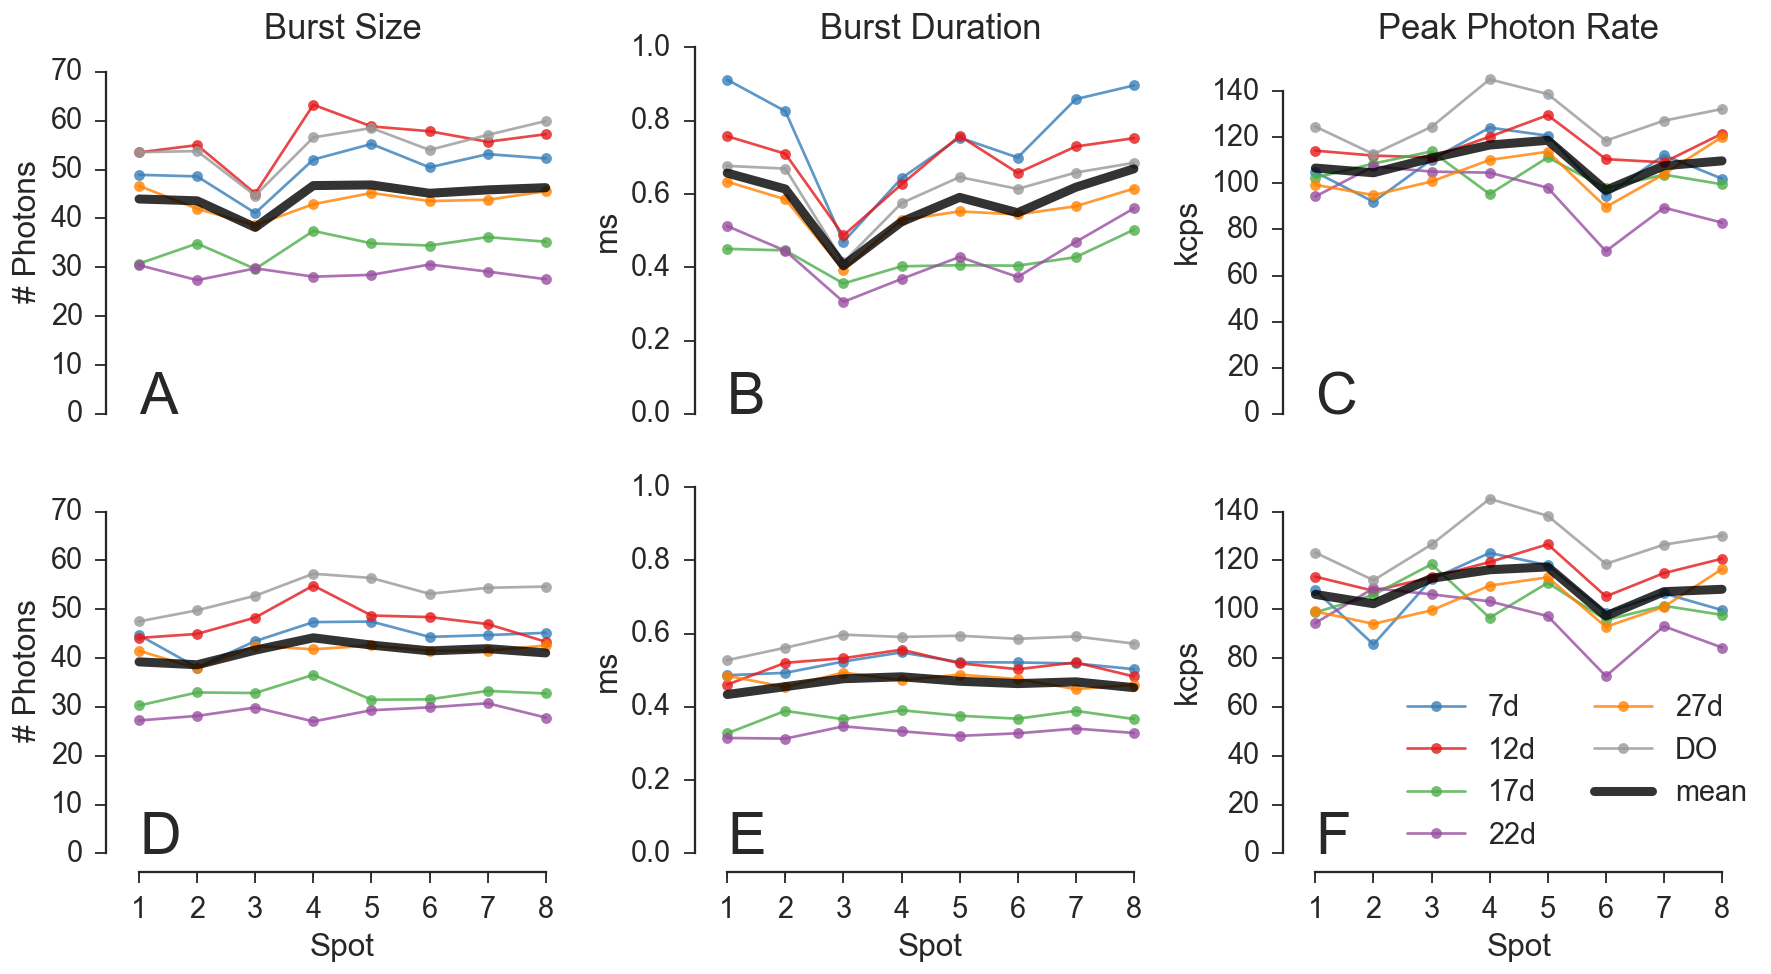

In [101]:
fig, ax = plt.subplots(2, 3, sharex=True, figsize=(16, 8), squeeze=True)
plt.subplots_adjust(wspace=0.35)

s_F_th1.plot(lw=1.5, marker='o', ms=6, alpha=0.8, ax=ax[0,0], legend=False,
             title='Burst Size')
s_F_th1.mean(1).plot(lw=5, color='k', alpha=0.8, label='mean', ax=ax[0,0])
ax[0,0].set_ylim(0, 75)
ax[0,0].set_ylabel('# Photons')
s_R_th1.plot(lw=1.5, marker='o', ms=6, alpha=0.8, ax=ax[1,0], legend=False)
s_R_th1.mean(1).plot(lw=5, color='k', alpha=0.8, label='mean', ax=ax[1,0])
ax[1,0].set_ylim(0, 75)
ax[1,0].set_ylabel('# Photons')

w_F_th1.plot(lw=1.5, marker='o', ms=6, alpha=0.8, ax=ax[0,1], legend=False,
             title='Burst Duration')
w_F_th1.mean(1).plot(lw=5, color='k', alpha=0.8, label='mean', ax=ax[0,1])
ax[0,1].set_ylim(0,1)
ax[0,1].set_ylabel('ms')
w_R_th1.plot(lw=1.5, marker='o', ms=6, alpha=0.8, ax=ax[1,1], legend=False,)
w_R_th1.mean(1).plot(lw=5, color='k', alpha=0.8, label='mean', ax=ax[1,1])
ax[1,1].set_ylim(0,1)
ax[1,1].set_ylabel('ms')

p_F_th1.plot(lw=1.5, marker='o', ms=6, alpha=0.8, ax=ax[0,2], legend=False,
             title='Peak Photon Rate')
p_F_th1.mean(1).plot(lw=5, color='k', alpha=0.8, label='mean', ax=ax[0,2])
ax[0,2].set_ylim(0, 159)
ax[0,2].set_ylabel('kcps')
p_R_th1.plot(lw=1.5, marker='o', ms=6, alpha=0.8, ax=ax[1,2], )
p_R_th1.mean(1).plot(lw=5, color='k', alpha=0.8, label='mean', ax=ax[1,2])
ax[1,2].set_ylim(0)
ax[1,2].set_ylabel('kcps')

plt.legend(loc='lower right', ncol=2,
           bbox_to_anchor=(1.05, -0.02), borderaxespad=0.)
plt.xlim(.75, 8.25)
sns.despine(offset=10, trim=True)
for x in ax[0,:]:
    x.xaxis.set_visible(False)
    #x.xaxis.set_ticklabels([])
    x.spines['bottom'].set_visible(False)
    
fs = 32
ax[0,0].text(1,0, 'A', fontsize=fs)
ax[1,0].text(1,0, 'D', fontsize=fs)
ax[0,1].text(1,0, 'B', fontsize=fs)
ax[1,1].text(1,0, 'E', fontsize=fs)
ax[0,2].text(1,0, 'C', fontsize=fs)
ax[1,2].text(1,0, 'F', fontsize=fs)
figname = ('8spot 5-dsDNA samples burst-stats vs ch F=%d, R=%dkcps lk=%.1f %s %s nt1=%d w1=%.1fms p1=%dkcps.png' % 
           (F, rate_th*1e-3, dx.leakage*100, sel_do, ph_sel, nt_th1, bw_th1, pr_th1))
savefig(figname)
figname